In [1]:
import pandas as pd
import numpy as np
import torch
import joblib
from sklearn.ensemble import ExtraTreesRegressor
import matplotlib.pyplot as plt

from cvae import CVAE
from generate import suggest

In [2]:
TARGET_YIELD = 1200.0   # MPa
N_SAMPLES = 50

# Load scalers and features
scalers = joblib.load("../data/processed/scalers.joblib")
feature_cols = scalers["feature_cols"]

In [5]:
df_gen = suggest(y_target_scalar=TARGET_YIELD, N=N_SAMPLES)

# Save raw suggestions
df_gen.to_csv(f"/Users/shrutisivakumar/Library/CloudStorage/OneDrive-Personal/College Stuff/Sem 5/Projects/DDMM/RHEA-Inverse-Design-Using-VAE/outputs/suggestions_y{int(TARGET_YIELD)}_raw.csv", index=False)

print(f"[INFO] Generated {len(df_gen)} candidates for target {TARGET_YIELD} MPa")

[INFO] Generated 50 candidates for target 1200.0 MPa


In [6]:
cat_cols = [
    "Equilibrium_Conditions_encoded",
    "Single_Multiphase_encoded",
    "Type_Present_Phases_encoded",
    "Tension_Compression_encoded"
]
df_gen[cat_cols] = df_gen[cat_cols].round().astype(int)

In [7]:
df_train = pd.read_csv("../data/encoded_data.csv")

drop_cols = [
    "Ref", "Composition",
    "Equilibrium_Conditions", "Single_Multiphase",
    "Type_Present_Phases", "Tension_Compression",
    "Yield_Strength"
]
X_train = df_train[feature_cols].fillna(df_train[feature_cols].median(numeric_only=True))
y_train = df_train["Yield_Strength"].fillna(df_train["Yield_Strength"].median())

# Train surrogate model
surrogate = ExtraTreesRegressor(n_estimators=500, random_state=42)
surrogate.fit(X_train, y_train)

ExtraTreesRegressor(n_estimators=500, random_state=42)

In [8]:
df_gen["Predicted_Yield_Strength"] = surrogate.predict(df_gen)

In [10]:
df_ranked = df_gen.sort_values(by="Predicted_Yield_Strength", ascending=False)
df_ranked.to_csv(f"/Users/shrutisivakumar/Library/CloudStorage/OneDrive-Personal/College Stuff/Sem 5/Projects/DDMM/RHEA-Inverse-Design-Using-VAE/outputs/suggestions_y{int(TARGET_YIELD)}_ranked.csv", index=False)

print(f"[INFO] Ranked suggestions saved to outputs/suggestions_y{int(TARGET_YIELD)}_ranked.csv")

[INFO] Ranked suggestions saved to outputs/suggestions_y1200_ranked.csv


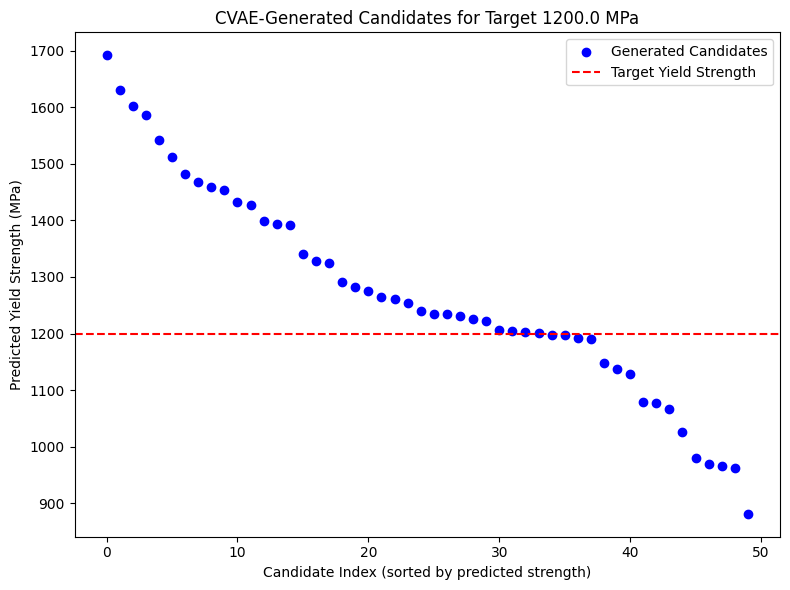

In [12]:
plt.figure(figsize=(8,6))
plt.scatter(range(len(df_ranked)), df_ranked["Predicted_Yield_Strength"], c='blue', label='Generated Candidates')
plt.axhline(y=TARGET_YIELD, color='r', linestyle='--', label='Target Yield Strength')
plt.xlabel("Candidate Index (sorted by predicted strength)")
plt.ylabel("Predicted Yield Strength (MPa)")
plt.title(f"CVAE-Generated Candidates for Target {TARGET_YIELD} MPa")
plt.legend()
plt.tight_layout()
plt.savefig(f"/Users/shrutisivakumar/Library/CloudStorage/OneDrive-Personal/College Stuff/Sem 5/Projects/DDMM/RHEA-Inverse-Design-Using-VAE/outputs/yield_strength_plot_y{int(TARGET_YIELD)}.png", dpi=300)
plt.show()

In [13]:
print(df_ranked["Predicted_Yield_Strength"].describe())

count      50.000000
mean     1269.785780
std       186.621569
min       881.120000
25%      1191.261300
50%      1236.995000
75%      1397.262450
max      1692.204400
Name: Predicted_Yield_Strength, dtype: float64
